# do-MPC を用いたモデル予測制御
本ノートブックでは，python 用ライブラリ "do-MPC" を用いたモデル予測制御の実装法を解説する．詳しくは，https://www.do-mpc.com/en/latest/getting_started.html を参照とする．

注意：do-MPC は LGPL ライセンスなので，改変した場合はコードの公開などが必要．

In [1]:
import numpy as np
import do_mpc
from casadi import *

## モデルの構築
do-MPC では，制御対象の数理モデルとして，連続時間系(微分方程式系) と離散時間系 (差分方程式系) の両方を扱うことができる．より一般の定式化としては，
$$
\begin{eqnarray}
\frac{\mathrm{d}x}{\mathrm{d}t}&=&f(x,u,z,p)\\
0&=&g(x,u,z,p)\\
y&=&h(x,u,z,p)
\end{eqnarray}
$$
のような代数微分方程式系を考えることができる．ここで，$x\in\mathbb{R}^{n_x}$ はシステムの状態，$u\in\mathbb{R}^{n_u}$ はシステムの制御入力，$z\in\mathbb{R}^{n_z}$ はシステムの代数的状態，$p\in\mathbb{R}^{n_p}$ はシステムの内部パラメータをあらわす．

In [2]:
# モデルの大枠を定義
model_type = 'continuous' # 離散時間系なら 'discrete'，連続時間系なら'continuous'
model = do_mpc.model.Model(model_type)

### 変数の設定
do-MPC 内の変数の定義の仕方について述べる．do-MPC では，以下のようなタイプの変数が用意されている．

| 種類 | コード上の表記 | 注意 |
| ---- | ---- | ---- |
| 状態 $x(t)$ | ``_x`` | 必須 |
| 制御入力 $u(t)$ | ``_u`` | 必須 |
| 代数的変数 $z$ | ``_z`` | オプション |
| 内部パラメータ $p$ | ``_p`` | オプション |
| 時変内部パラメータ $p(t)$ | ``_tvp`` | オプション |

ここで，Continuous Stirred Tank Reactor (CSTR) を例題として考えてみる．
$$
\begin{eqnarray}
\dot{C}_{\mathrm{A}}&=&F\cdot(C_{\mathrm{A},0}-C_{\mathrm{A}})-k_1\cdot C_{\mathrm{A}}-k_{3}C_{\mathrm{A}}^2\\
\dot{C}_{\mathrm{B}}&=&-F\cdot C_{\mathrm{B}}+k_1\cdot C_{\mathrm{A}}-k_2\cdot C_{\mathrm{B}}\\
\dot{T}_{\mathrm{R}}&=&\frac{k_1\cdot C_{\mathrm{A}}\cdot H_{\mathrm{R},ab}+k_2\cdot C_{\mathrm{B}}\cdot H_{\mathrm{R},bc}+k_3\cdot C_{\mathrm{A}}^{2}\cdot H_{\mathrm{R},ad}}{-\rho\cdot c_p}+F\cdot (T_{\mathrm{in}}-T_{\mathrm{R}})+\frac{K_w\cdot A_{\mathrm{R}}\cdot(T_{\mathrm{K}}-T_{\mathrm{R}})}{\rho\cdot c_p\cdot V_{\mathrm{R}}}\\
\dot{T}_{\mathrm{K}}&=&\frac{\dot{Q}+K_{w}\cdot A_{\mathrm{R}}\cdot T_{\mathrm{dif}}}{m_{k}\cdot C_{p,k}}
\end{eqnarray}
$$
ただし，
$$
\begin{eqnarray}
k_{1}&=&\beta\cdot k_{0,ab}\cdot\exp\left(\frac{-E_{\mathrm{A},ab}}{T_{\mathrm{R}}+273.15}\right)\\
k_{2}&=&k_{0,bc}\cdot\exp\left(\frac{-E_{\mathrm{A},bc}}{T_{\mathrm{R}}+273.15}\right)\\
k_{3}&=&k_{0,ad}\cdot\exp\left(\frac{-\alpha\cdot E_{\mathrm{A},ad}}{T_{\mathrm{R}}+273.15}\right)
\end{eqnarray}
$$
である．

この例題における状態は，槽内の物質Aの濃度 $C_{\mathrm{A}}$，物質Bの濃度 $C_{\mathrm{B}}$，反応器内の温度 $T_{\mathrm{R}}$，熱交換器の温度 $T_{\mathrm{K}}$ の4つである．do-MPC では，状態を以下のようにシンボリック変数として定義する．

In [3]:
# 状態変数の定義
C_a = model.set_variable(var_type='_x', var_name='C_a', shape=(1,1))
C_b = model.set_variable(var_type='_x', var_name='C_b', shape=(1,1))
T_R = model.set_variable(var_type='_x', var_name='T_R', shape=(1,1))
T_K = model.set_variable(var_type='_x', var_name='T_K', shape=(1,1))

以下のように，ベクトルとして定義することも可能である．

``
x_vec_ = model.set_variable(var_type='_x', var_name='x_vec_', shape=(4,1))
``

モデル内の変数やパラメータを取得したい場合，以下のような操作が可能である．

In [4]:
model.x

``x`` のほかに，``u``，``z``，``p``，``tvp``，``y``，``aux`` が呼び出し可能である．また，各要素にも以下のようにアクセスが可能である．

In [5]:
model.x['C_a']

SX(C_a)

またシンボリック変数に，どのような値が含まれているかも確認できる．

In [6]:
model.x.keys()

['C_a', 'C_b', 'T_R', 'T_K']

In [7]:
model.x.labels()

['[C_a,0]', '[C_b,0]', '[T_R,0]', '[T_K,0]']

CSTR の制御変数としては，フィード流量 $F$ と加熱量 $\dot{Q}$ を考える．

In [8]:
F = model.set_variable(var_type='_u', var_name='F')
Q_dot = model.set_variable(var_type='_u', var_name='Q_dot')

今回，値が確定しているかつ既知なパラメータは通常の定数として定義し，未知なパラメータは ``_p`` や ``_tvp`` で定義する．

In [9]:
# 既知なパラメータ
K0_ab = 1.287e12 # K0 [h^-1]
K0_bc = 1.287e12 # K0 [h^-1]
K0_ad = 9.043e9 # K0 [l/mol.h]
R_gas = 8.3144621e-3 # 理想気体定数
E_A_ab = 9758.3*1.00 #* R_gas# [kj/mol]
E_A_bc = 9758.3*1.00 #* R_gas# [kj/mol]
E_A_ad = 8560.0*1.0 #* R_gas# [kj/mol]
H_R_ab = 4.2 # [kj/mol A]
H_R_bc = -11.0 # [kj/mol B] Exothermic
H_R_ad = -41.85 # [kj/mol A] Exothermic
Rou = 0.9342 # Density [kg/l]
Cp = 3.01 # Specific Heat capacity [kj/Kg.K]
Cp_k = 2.0 # Coolant heat capacity [kj/kg.k]
A_R = 0.215 # Area of reactor wall [m^2]
V_R = 10.01 #0.01 # Volume of reactor [l]
m_k = 5.0 # Coolant mass[kg]
K_w = 4032.0 # [kj/h.m^2.K]
C_A0 = (5.7+4.5)/2.0*1.0 # Concentration of A in input Upper bound 5.7 lower bound 4.5 [mol/l]

In [10]:
# 不確かなパラメータ
alpha = model.set_variable(var_type='_p', var_name='alpha')
beta = model.set_variable(var_type='_p', var_name='beta')
T_in = model.set_variable(var_type='_p', var_name='T_in')

可視化の際に使うため，以下の変数を用意．

In [11]:
T_dif = model.set_expression(expr_name='T_dif', expr=T_R-T_K) # 状態変数ではないが後で利用する人為変数

### 微分方程式の立式

In [12]:
# 反応係数
K_1 = beta * K0_ab * exp((-E_A_ab)/((T_R+273.15)))
K_2 =  K0_bc * exp((-E_A_bc)/((T_R+273.15)))
K_3 = K0_ad * exp((-alpha*E_A_ad)/((T_R+273.15)))

各変数ごとに右辺の式を定義．

In [13]:
model.set_rhs('C_a', F*(C_A0 - C_a) -K_1*C_a - K_3*(C_a**2))
model.set_rhs('C_b', -F*C_b + K_1*C_a - K_2*C_b)
model.set_rhs('T_R', ((K_1*C_a*H_R_ab + K_2*C_b*H_R_bc + K_3*(C_a**2)*H_R_ad)/(-Rou*Cp)) + F*(T_in-T_R) +(((K_w*A_R)*(-T_dif))/(Rou*Cp*V_R)))
model.set_rhs('T_K', (Q_dot + K_w*A_R*(T_dif))/(m_k*Cp_k))

最後に ``setup()`` することでモデルの定義が完了する．

In [14]:
model.setup()

## MPC 制御器の構築
モデル予測制御をおこなうための制御器を定義する．

In [15]:
mpc = do_mpc.controller.MPC(model)

### MPC ソルバのパラメータ
``n_horizon`` は予測ホライゾンをあらわす．``t_step`` は制御周期をあらわす．これらは必須パラメータである．また，``n_robust`` はシナリオベースのロバストモデル予測制御用のパラメータである．連続時間システムはデフォルトでコロケーション法 ``collocation`` が用いられる．

In [16]:
setup_mpc = {
    'n_horizon': 20, 
    'n_robust': 1, 
    'open_loop': 0,
    't_step': 0.005, 
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 2,
    'collocation_ni': 2,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    #'nlpsol_opts': {'ipopt.linear_solver': 'MA27'}
}

mpc.set_param(**setup_mpc)

各変数間でスケールに差がありすぎるため，以下のようにスケール調整する．

In [17]:
mpc.scaling['_x', 'T_R'] = 100
mpc.scaling['_x', 'T_K'] = 100
mpc.scaling['_u', 'Q_dot'] = 2000
mpc.scaling['_u', 'F'] = 100

### 評価関数
MPCの評価関数は以下のように定義される．
$$
J=\sum_{k=0}^{K-1}\left(\ell(x_k,u_k,z_k,p)+\Delta u_k^{\top}R\ \Delta u_k\right) + \phi(x_K)
$$

$\ell$ はステージコスト，$\phi$ は終端コストをあらわす．$\Delta u_k^{\top}R\Delta u_k$ の項については制御入力の変更の大きさ
$$
\Delta u_k:=u_k-u_{k-1}
$$
に関する罰則を与えるものである．

In [18]:
_x = model.x
mterm = (_x['C_b'] - 0.6)**2 # 終端コスト
lterm = (_x['C_b'] - 0.6)**2 # ステージコスト

mpc.set_objective(mterm=mterm, lterm=lterm)

mpc.set_rterm(F=0.1, Q_dot = 1e-3) # 制御入力のコスト

### 制約
制約を考慮できるのは MPC の利点である．状態や制御入力に関する制約を以下のように定義する．

In [19]:
# 状態の下限
mpc.bounds['lower', '_x', 'C_a'] = 0.1
mpc.bounds['lower', '_x', 'C_b'] = 0.1
mpc.bounds['lower', '_x', 'T_R'] = 50
mpc.bounds['lower', '_x', 'T_K'] = 50

# 状態の上限
mpc.bounds['upper', '_x', 'C_a'] = 2
mpc.bounds['upper', '_x', 'C_b'] = 2
mpc.bounds['upper', '_x', 'T_K'] = 140

# 入力の下限
mpc.bounds['lower', '_u', 'F'] = 5
mpc.bounds['lower', '_u', 'Q_dot'] = -8500

# 入力の上限
mpc.bounds['upper', '_u', 'F'] = 100
mpc.bounds['upper', '_u', 'Q_dot'] = 0.0

ハード制約が厳しすぎると，数値不安定性が生じたり，実行可能解が見つからない場合がありうる．そこで，以下のようにソフト制約を定義することもできる．
```
mpc.set_nl_cons('T_R', _x['T_R'], ub=140, soft_constraint=True, penalty_term_cons=1e2)
```

In [20]:
# ソフト制約の定義
mpc.set_nl_cons('T_R', _x['T_R'], ub=140, soft_constraint=True, penalty_term_cons=1e2)

SX(T_R)

### 不確かなパラメータの扱い
不確かなパラメータに対して，ロバストモデル予測制御を行うため，複数シナリオを考える．本例題では，$\alpha,\ \beta,\ T_{in}$ が不確かであったが，$\alpha,\ \beta$ のみ3つシナリオを用意し，$T_{in}$ は $130.0$ であると仮定する．

In [21]:
alpha_var = np.array([1., 1.05, 0.95])
beta_var = np.array([1., 1.1, 0.9])
T_in_var = np.array([130.0])

mpc.set_uncertainty_values(alpha = alpha_var, beta = beta_var, T_in = T_in_var)

もし，``n_robust=1`` としたとき，9つの異なるケースを考慮してモデル予測制御することになる．

以下のように mpc ソルバの設定を完了する．

In [22]:
mpc.setup()

## 実験環境（シミュレータ）の定義

In [23]:
simulator = do_mpc.simulator.Simulator(model)

In [24]:
params_simulator = {
    'integration_tool': 'cvodes', # https://computing.llnl.gov/projects/sundials/cvode
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 0.005 # 同じ値にすること
}

simulator.set_param(**params_simulator)

### 不確かなパラメータの扱い

In [25]:
p_num = simulator.get_p_template()
tvp_num = simulator.get_tvp_template()

In [26]:
type(p_num)

casadi.tools.structure3.DMStruct

In [27]:
type(tvp_num)

casadi.tools.structure3.DMStruct

In [28]:
p_num.keys()

['default', 'alpha', 'beta', 'T_in']

In [29]:
tvp_num.keys()

['default']

時間に合わせてパラメータの値を設定する関数が必要である．

In [30]:
def p_fun(t_now):
    p_num['alpha'] = 1
    p_num['beta'] = 1
    p_num['T_in'] = 130.0
    return p_num

def tvp_fun(t_now):
    return tvp_num

In [31]:
simulator.set_p_fun(p_fun)
simulator.set_tvp_fun(tvp_fun)

MPCソルバ同様，シミュレータもセットアップを完了する．

In [32]:
simulator.setup()

## 閉ループシミュレーション

In [33]:
# 初期状態を定義する．
C_a_0 = 0.8 # タンク内の A の濃度 [mol/l]
C_b_0 = 0.5 # タンク内の B の濃度 [mol/l]
T_R_0 = 134.14 #[C]
T_K_0 = 130.0 #[C]
x0 = np.array([C_a_0, C_b_0, T_R_0, T_K_0]).reshape(-1,1)

mpc.x0 = x0
simulator.x0 = x0

mpc.set_initial_guess()

In [34]:
mpc.x0

In [35]:
mpc.x0['C_a']

DM(0.8)

### 可視化ツールの定義
do-mpc では ``graphics`` を使って結果を可視化する．

In [36]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [37]:
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3

In [38]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

In [39]:
%%capture
fig, ax = plt.subplots(5, sharex=True, figsize=(16,12))

# Configure plot:
sim_graphics.add_line(var_type='_x', var_name='C_a', axis=ax[0])
sim_graphics.add_line(var_type='_x', var_name='C_b', axis=ax[0])
sim_graphics.add_line(var_type='_x', var_name='T_R', axis=ax[1])
sim_graphics.add_line(var_type='_x', var_name='T_K', axis=ax[1])
sim_graphics.add_line(var_type='_aux', var_name='T_dif', axis=ax[2])
sim_graphics.add_line(var_type='_u', var_name='Q_dot', axis=ax[3])
sim_graphics.add_line(var_type='_u', var_name='F', axis=ax[4])
mpc_graphics.add_line(var_type='_x', var_name='C_a', axis=ax[0])
mpc_graphics.add_line(var_type='_x', var_name='C_b', axis=ax[0])
mpc_graphics.add_line(var_type='_x', var_name='T_R', axis=ax[1])
mpc_graphics.add_line(var_type='_x', var_name='T_K', axis=ax[1])
mpc_graphics.add_line(var_type='_aux', var_name='T_dif', axis=ax[2])
mpc_graphics.add_line(var_type='_u', var_name='Q_dot', axis=ax[3])
mpc_graphics.add_line(var_type='_u', var_name='F', axis=ax[4])
ax[0].set_ylabel('c [mol/l]')
ax[1].set_ylabel('T [K]')
ax[2].set_ylabel('$\Delta$ T [K]')
ax[3].set_ylabel('Q [kW]')
ax[4].set_ylabel('Flow [l/h]')
ax[4].set_xlabel('time [h]')

# Add labels
label_lines = sim_graphics.result_lines['_x', 'C_a']+sim_graphics.result_lines['_x', 'C_b']
ax[0].legend(label_lines, ['C_a', 'C_b'])
label_lines = sim_graphics.result_lines['_x', 'T_R']+sim_graphics.result_lines['_x', 'T_K']
ax[1].legend(label_lines, ['T_R', 'T_K'])

fig.align_ylabels()

### シミュレータを動かしてみる

In [40]:
u0 = np.array([[50.],[-4250.]])
for k in range(50):
    simulator.make_step(u0)
    #print(x0)

シミュレーションの結果を表示すると，

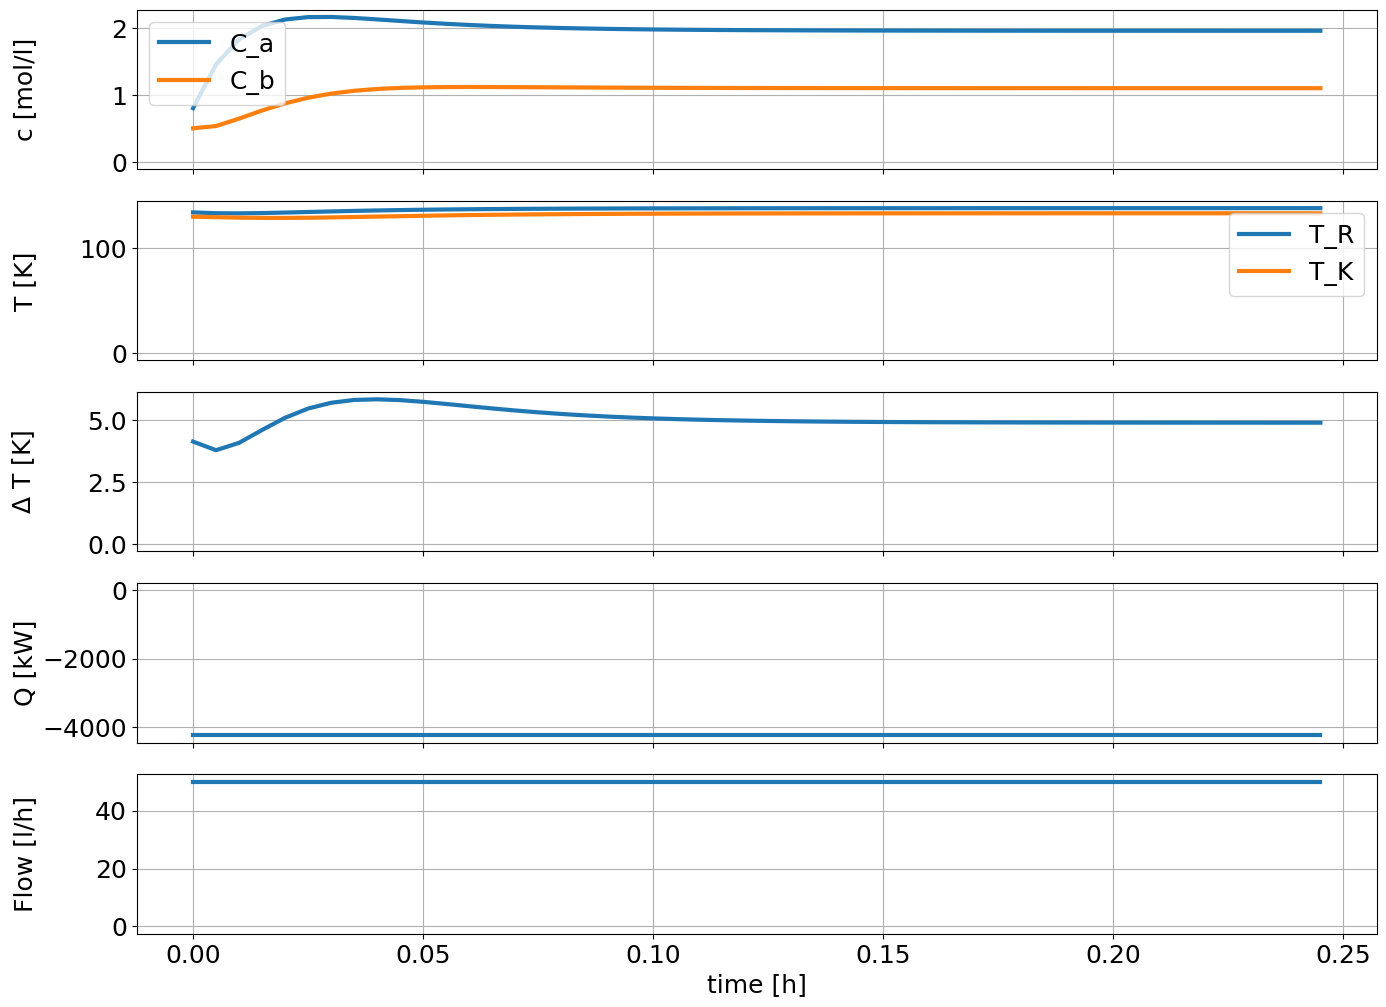

In [41]:
sim_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
sim_graphics.reset_axes()
# Show the figure:
fig

### 最適化ソルバを実行する
現在印可すべき制御入力を計算するため，``optimizer.make_step(x0)`` を呼び出す．

In [42]:
u0 = mpc.make_step(x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    20884
Number of nonzeros in inequality constraint Jacobian.:      360
Number of nonzeros in Lagrangian Hessian.............:     5907

Total number of variables............................:     5832
                     variables with only lower bounds:     1377
                variables with lower and upper bounds:     3951
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5044
Total number of inequality c

与えられた最適制御問題に関して，IPOPT からの出力を取得した結果である．EXIT で最適解が見つかっているかが重要である．

In [43]:
sim_graphics.clear()

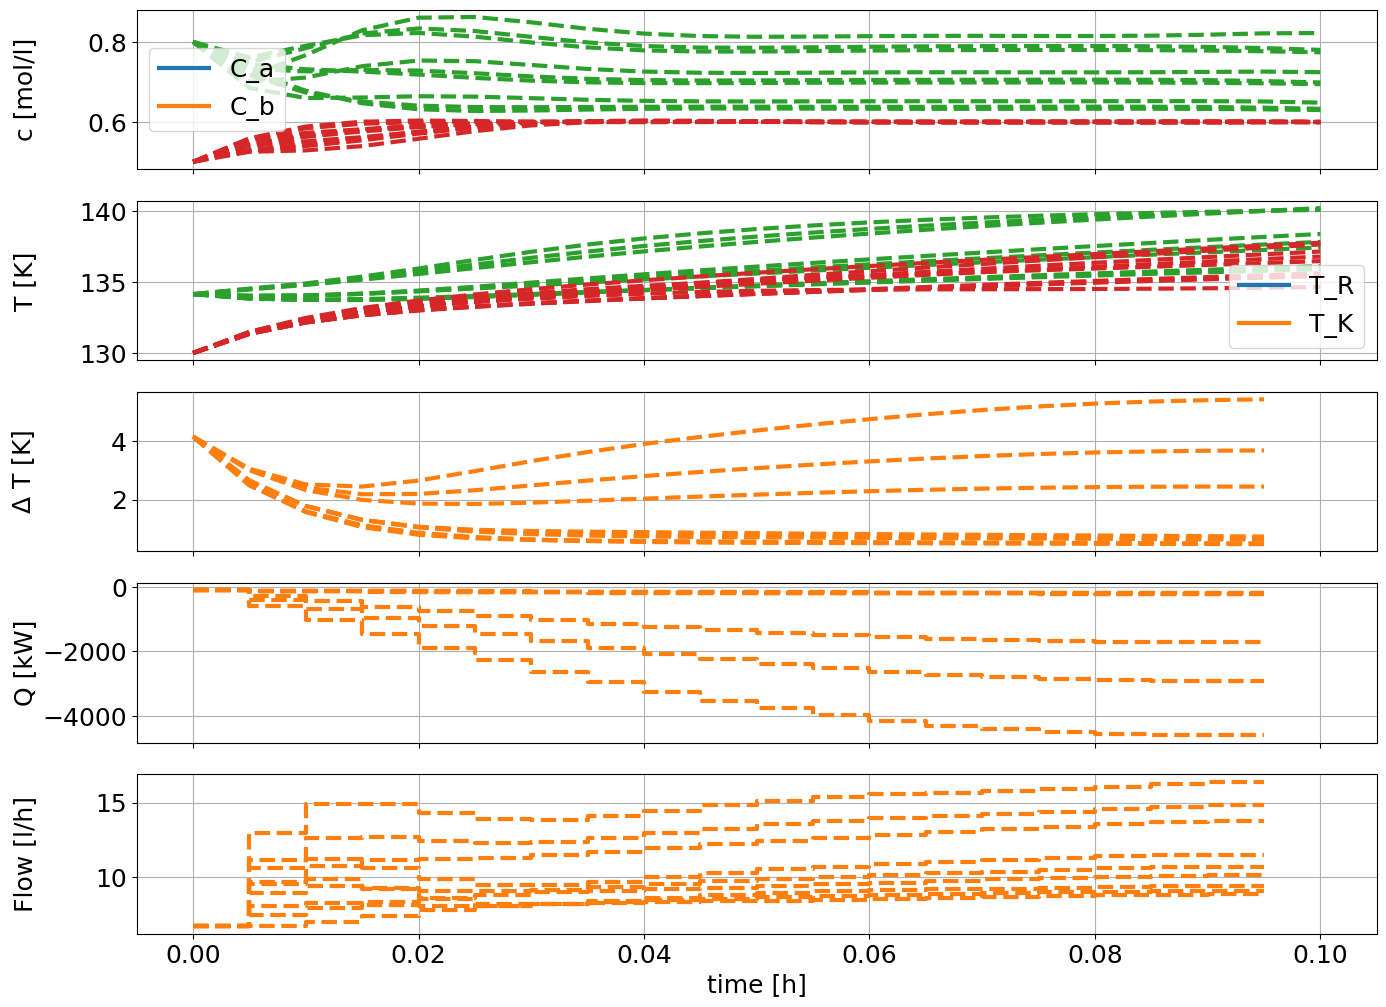

In [44]:
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
# Show the figure:
fig

### グラフの調整
上記で可視化した結果を調整する．

In [45]:
mpc_graphics.pred_lines

In [46]:
mpc_graphics.pred_lines['_x', 'C_a'] # ロバストMPCの候補の数存在する

In [47]:
# Change the color for the three states:
for line_i in mpc_graphics.pred_lines['_x', 'C_a']: line_i.set_color('#1f77b4') # blue
for line_i in mpc_graphics.pred_lines['_x', 'C_b']: line_i.set_color('#ff7f0e') # orange
for line_i in mpc_graphics.pred_lines['_x', 'T_R']: line_i.set_color('#1f77b4') # blue
for line_i in mpc_graphics.pred_lines['_x', 'T_K']: line_i.set_color('#ff7f0e') # orange
for line_i in mpc_graphics.pred_lines['_aux', 'T_dif']: line_i.set_color('#1f77b4') # blue
# Change the color for the two inputs:
for line_i in mpc_graphics.pred_lines['_u', 'Q_dot']: line_i.set_color('#1f77b4')
for line_i in mpc_graphics.pred_lines['_u', 'F']: line_i.set_color('#1f77b4')

# Make all predictions transparent:
for line_i in mpc_graphics.pred_lines.full: line_i.set_alpha(0.2)

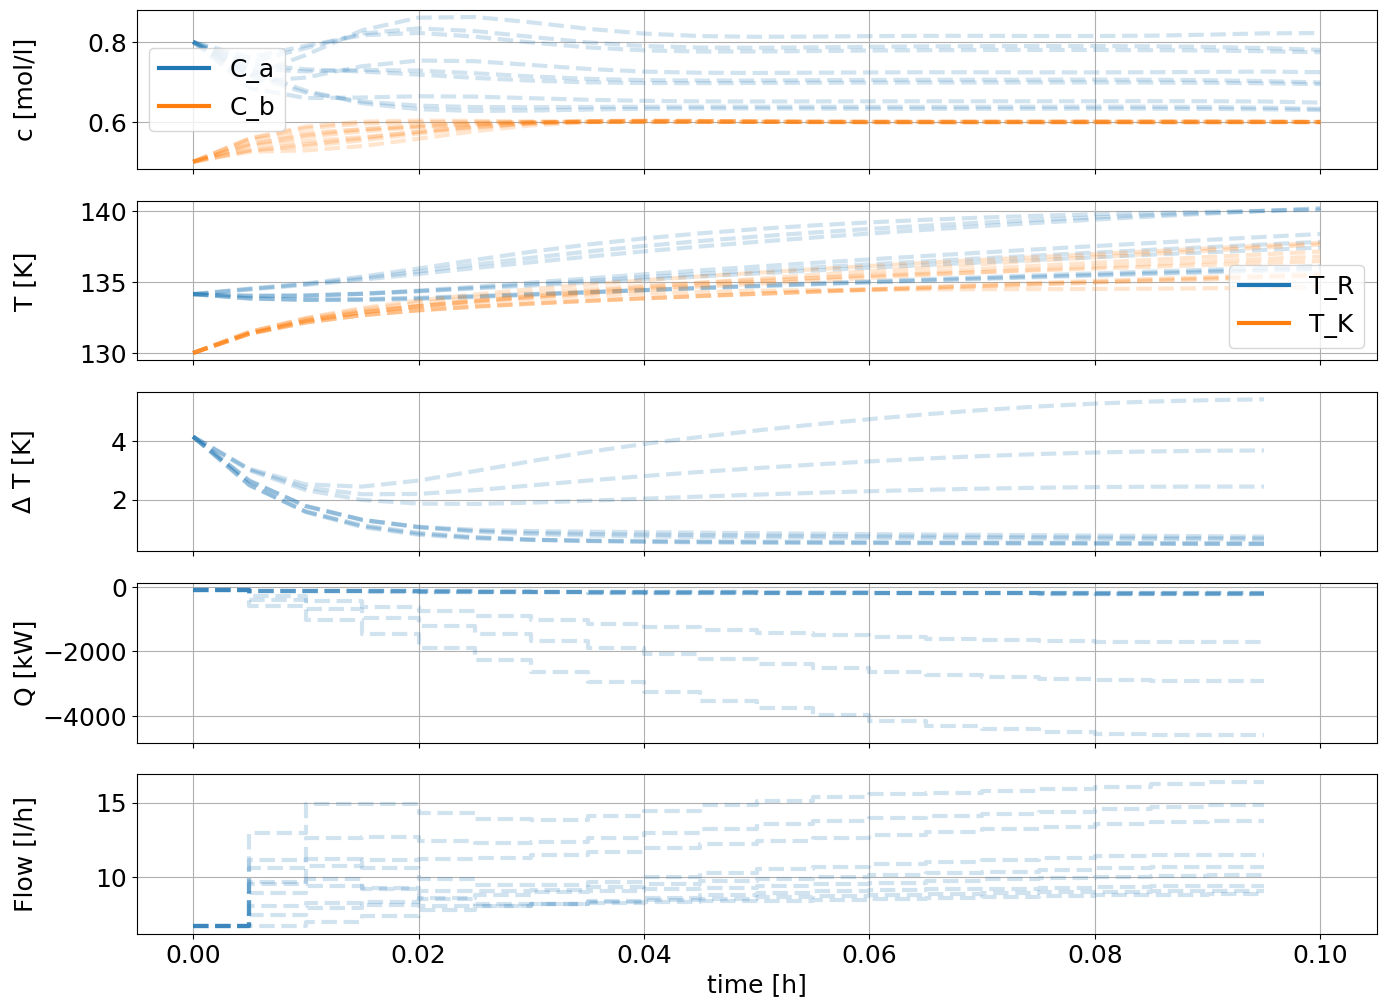

In [48]:
fig

同様に結果のグラフも色を変えられる．

### 制御を実行する

In [49]:
simulator.reset_history()

# 初期状態を定義する．
C_a_0 = 0.8 # タンク内の A の濃度 [mol/l]
C_b_0 = 0.5 # タンク内の B の濃度 [mol/l]
T_R_0 = 134.14 #[C]
T_K_0 = 130.0 #[C]
x0 = np.array([C_a_0, C_b_0, T_R_0, T_K_0]).reshape(-1,1)

simulator.x0 = x0
mpc.reset_history()

50 ステップ，モデル予測制御で制御した結果を示す．

In [50]:
%%capture
for i in range(50):
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)

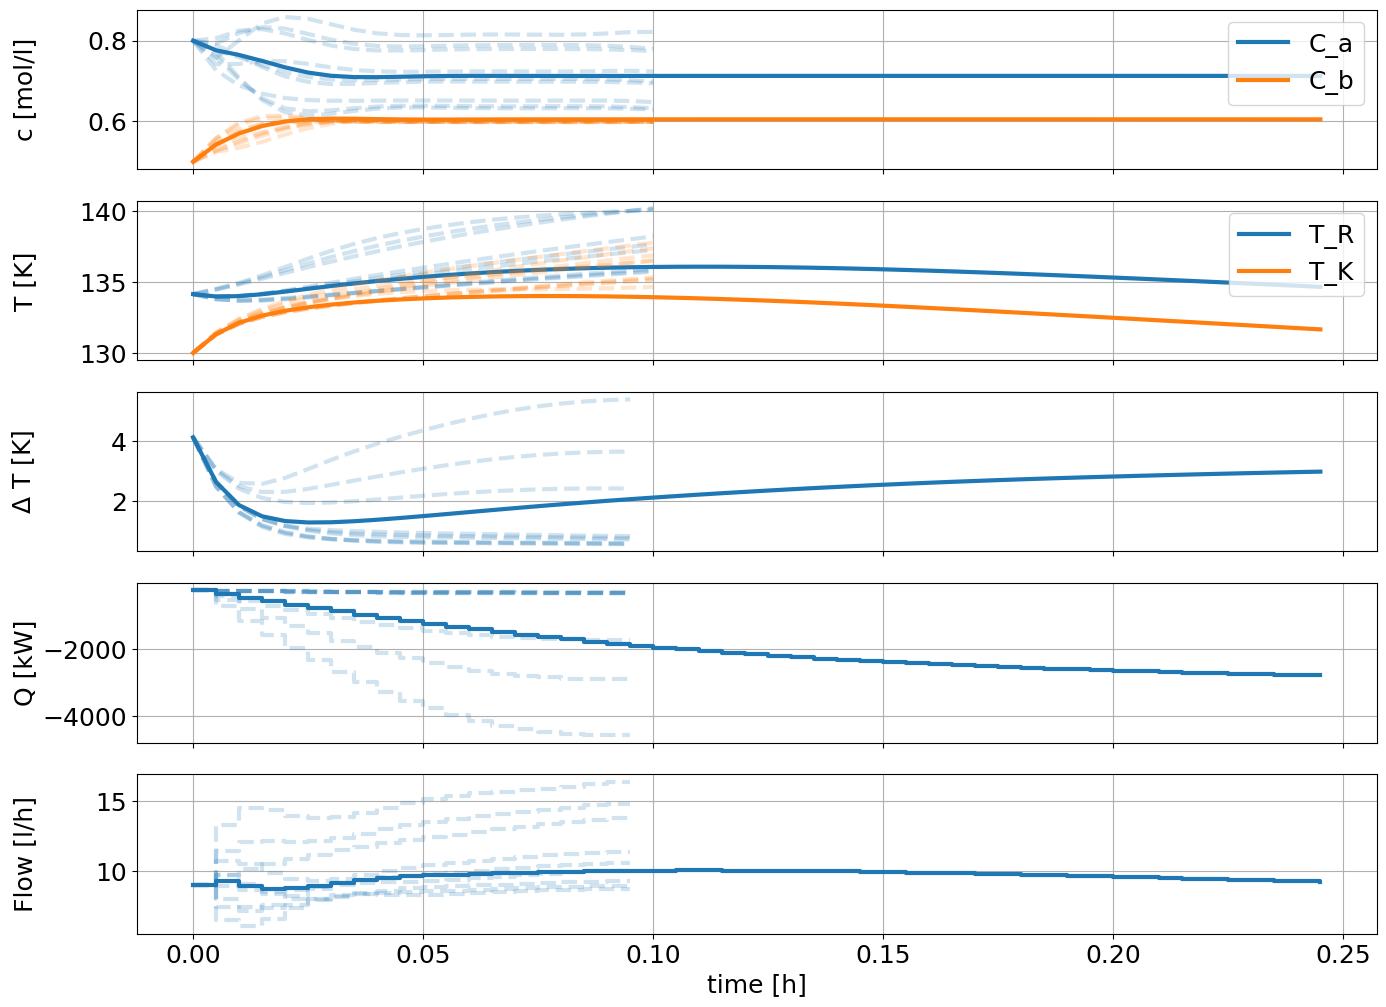

In [51]:
# t=0 における予測線
mpc_graphics.plot_predictions(t_ind=0)
# 現在までの結果
sim_graphics.plot_results()
sim_graphics.reset_axes()

# Change the color for the three states:
for line_i in mpc_graphics.pred_lines['_x', 'C_a']: line_i.set_color('#1f77b4') # blue
for line_i in mpc_graphics.pred_lines['_x', 'C_b']: line_i.set_color('#ff7f0e') # orange
for line_i in mpc_graphics.pred_lines['_x', 'T_R']: line_i.set_color('#1f77b4') # blue
for line_i in mpc_graphics.pred_lines['_x', 'T_K']: line_i.set_color('#ff7f0e') # orange
for line_i in mpc_graphics.pred_lines['_aux', 'T_dif']: line_i.set_color('#1f77b4') # blue
# Change the color for the two inputs:
for line_i in mpc_graphics.pred_lines['_u', 'Q_dot']: line_i.set_color('#1f77b4')
for line_i in mpc_graphics.pred_lines['_u', 'F']: line_i.set_color('#1f77b4')

# Make all predictions transparent:
for line_i in mpc_graphics.pred_lines.full: line_i.set_alpha(0.2)
    
fig

## データ処理

### 結果の保存と取得
do-MPC では，``save_results`` と ``load_results`` によって，``do_mpc.data`` を保存したり，ロードしたりできる．

In [52]:
from do_mpc.data import save_results, load_results

In [53]:
save_results([mpc, simulator])

In [54]:
!ls ./results/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [55]:
results = load_results('./results/results.pkl')

In [56]:
results

{'mpc': <do_mpc.data.MPCData at 0x20bc619b370>,
 'simulator': <do_mpc.data.Data at 0x20bd93ab7f0>}

In [57]:
results['mpc']

In [58]:
x = results['mpc']['_x']
x.shape

(50, 4)

In [59]:
C_a = results['mpc']['_x','C_a']
C_a.shape

(50, 1)

## 動画による可視化

In [60]:
from matplotlib.animation import FuncAnimation, ImageMagickWriter

In [61]:
# Update properties for all prediction lines:
for line_i in mpc_graphics.pred_lines.full:
    line_i.set_linewidth(2)
# Highlight nominal case:　公式コードだと numpy のバージョンによってはここでエラー
#for line_i in np.sum(mpc_graphics.pred_lines['_x', :, :,0]):
#    line_i.set_linewidth(5)
#for line_i in np.sum(mpc_graphics.pred_lines['_u', :, :,0]):
#    line_i.set_linewidth(5)
#for line_i in np.sum(mpc_graphics.pred_lines['_aux', :, :,0]):
#    line_i.set_linewidth(5)
lines = mpc_graphics.pred_lines['_x', :, :, 0]
flattened_lines = [line for sublist1 in lines for sublist2 in sublist1 for line in (sublist2 if isinstance(sublist2, (list, tuple, np.ndarray)) else [sublist2])]
for line_i in flattened_lines:
    line_i.set_linewidth(5)

In [62]:
def update(t_ind):
    print('Writing frame: {}.'.format(t_ind), end='\r')
    sim_graphics.plot_results(t_ind=t_ind)
    mpc_graphics.plot_predictions(t_ind=t_ind)
    mpc_graphics.reset_axes()
    lines = mpc_graphics.result_lines.full
    return lines

n_steps = mpc.data['_time'].shape[0]


anim = FuncAnimation(fig, update, frames=n_steps, blit=True)

gif_writer = ImageMagickWriter(fps=5)
anim.save('./results/anim_CSTR.gif', writer=gif_writer) # https://imagemagick.org/script/download.php からインストール必須

Writing frame: 49.